<a href="https://colab.research.google.com/github/uneeknaymuh/Time-Series-GANs/blob/main/DopplerGANger_PyTorch_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%%capture
!pip install numpy pandas matplotlib torch gretel-synthetics

In [5]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, Normalization

In [6]:
S3_BASE_URL = "https://gretel-public-website.s3.us-west-2.amazonaws.com/datasets/wiki-web-traffic-data/"

wwt = pd.read_csv(S3_BASE_URL + "wikipedia-web-traffic-training.csv", index_col=0)
wwt.drop(columns=["domain", "access", "agent"], inplace=True)
assert wwt.shape[1] == 553
ATTRIBUTE_COLUMNS = ["domain_name", "access_name", "agent_name"]

wwt

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,domain_name,access_name,agent_name
0,-0.333795,-0.319665,-0.314942,-0.308651,-0.291297,-0.312655,-0.309529,-0.306918,-0.310413,-0.317752,...,-0.269336,-0.277937,-0.258538,-0.235855,-0.241672,-0.254042,-0.266611,es.wikipedia.org,all-access,all-agents
1,-0.692347,-0.699509,-0.744500,-0.769260,-0.744500,-0.846174,-0.784077,-0.724269,-0.699509,-0.769260,...,-0.692347,-0.673278,-0.667587,-0.699509,-0.707164,-0.769260,-0.707164,ru.wikipedia.org,desktop,all-agents
2,-0.291111,-0.298633,-0.346250,-0.431433,-0.404062,-0.324597,-0.317989,-0.342335,-0.344124,-0.390935,...,-0.638474,-0.587933,-0.553338,-0.528577,-0.531794,-0.563716,-0.596365,es.wikipedia.org,all-access,all-agents
3,-0.565913,-0.565913,-0.570443,-0.570443,-0.596365,-0.575165,-0.605490,-0.570443,-0.518001,-0.580098,...,-0.630251,-0.608707,-0.572779,-0.590673,-0.559447,-0.582649,-0.561561,en.wikipedia.org,all-access,spider
4,-0.430120,-0.547547,-0.608707,-0.538521,-0.505735,-0.449311,-0.408269,-0.395140,-0.390022,-0.418952,...,-0.513760,-0.542044,-0.512382,-0.518001,-0.503184,-0.519452,-0.540268,en.wikipedia.org,all-access,spider
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-0.464239,-0.490115,-0.432762,-0.561561,-0.605490,-0.500691,-0.490115,-0.491241,-0.443271,-0.507033,...,-0.599324,-0.501931,-0.452459,-0.414896,-0.369715,-0.438243,-0.472531,es.wikipedia.org,desktop,all-agents
49996,-0.673278,-0.744500,-0.801182,-0.756191,-0.692347,-0.756191,-0.821413,-0.784077,-0.801182,-0.707164,...,-0.657011,-0.673278,-0.744500,-0.685620,-0.647356,-0.699509,-0.642826,en.wikipedia.org,all-access,spider
49997,-0.724269,-0.630251,-0.679278,-0.715387,-0.638474,-0.784077,-0.685620,-0.662173,-0.662173,-0.599324,...,-0.593483,-0.563716,-0.596365,-0.724269,-0.638474,-0.685620,-0.707164,de.wikipedia.org,mobile-web,all-agents
49998,-0.371240,-0.364898,-0.355182,-0.361681,-0.349674,-0.365261,-0.354520,-0.368210,-0.376750,-0.377967,...,-0.209451,-0.196879,-0.185372,-0.187258,-0.191280,-0.187918,-0.212715,commons.wikimedia.org,all-access,all-agents


In [7]:
# Extract numpy arrays for charts
wwt_attributes = wwt[ATTRIBUTE_COLUMNS].to_numpy()
print(wwt_attributes.shape)
wwt_features = np.expand_dims(wwt.drop(columns=ATTRIBUTE_COLUMNS).to_numpy(), axis=-1)
print(wwt_features.shape)

(50000, 3)
(50000, 550, 1)


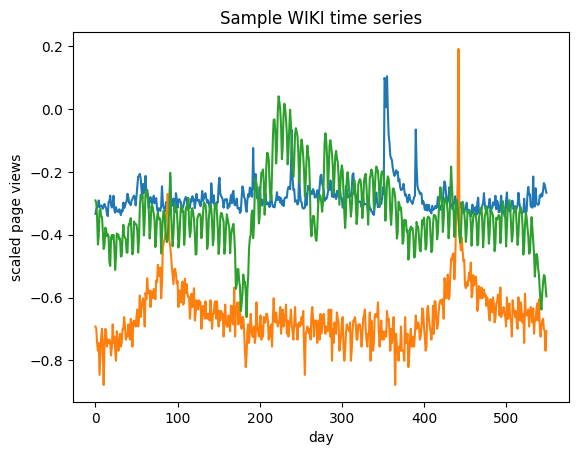

In [8]:
# Plot a few time series
for index in [0,1,2]:
    plt.plot(wwt_features[index,:,0])

plt.xlabel("day")
plt.ylabel("scaled page views")
plt.title("Sample WIKI time series")
plt.show()


In [9]:
# Autocorrelation computation
# From https://github.com/fjxmlzn/DoppelGANger/issues/20#issuecomment-858234890
EPS = 1e-8

def autocorr(X, Y):
    Xm = torch.mean(X, 1).unsqueeze(1)
    Ym = torch.mean(Y, 1).unsqueeze(1)
    r_num = torch.sum((X - Xm) * (Y - Ym), 1)
    r_den = torch.sqrt(torch.sum((X - Xm)**2, 1) * torch.sum((Y - Ym)**2, 1))

    r_num[r_num == 0] = EPS
    r_den[r_den == 0] = EPS

    r = r_num / r_den
    r[r > 1] = 0
    r[r < -1] = 0

    return r


def get_autocorr(feature):
    feature = torch.from_numpy(feature)
    feature_length = feature.shape[1]
    autocorr_vec = torch.Tensor(feature_length - 2)

    for j in range(1, feature_length - 1):
        autocorr_vec[j - 1] = torch.mean(autocorr(feature[:, :-j],
                                                  feature[:, j:]))

    return autocorr_vec.cpu().detach().numpy()

In [10]:
# Train DGAN model

config1 = DGANConfig(
    max_sequence_len=wwt.shape[1] - len(ATTRIBUTE_COLUMNS),
    sample_len=10,
    use_attribute_discriminator=True,
    gradient_penalty_coef=10.0,
    attribute_gradient_penalty_coef=10.0,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    attribute_discriminator_learning_rate=1e-4,
    attribute_loss_coef=1.0,
    apply_feature_scaling=False,  # features are already scaled to [-1,1]
    apply_example_scaling=True,
    normalization=Normalization.MINUSONE_ONE,
    batch_size=1000,
    epochs=400,
)

wwt_model1 = DGAN(config=config1)

start_time = time.time()
wwt_model1.train_dataframe(
    df=wwt,
    attribute_columns=ATTRIBUTE_COLUMNS,
)

# Generate data

synthetic1 = wwt_model1.generate_dataframe(50000)

end_time = time.time()
print("Elapsed time: {} seconds".format(end_time - start_time))

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.10/dist-packages/category_encoders/one_hot.py:187: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.10/dist-packages/category_encoders/one_hot.py:187: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categor

Elapsed time: 1294.9667959213257 seconds


In [11]:
synthetic1

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,domain_name,access_name,agent_name
0,-0.233387,-0.210401,-0.208126,-0.227194,-0.226939,-0.20018,-0.201785,-0.237107,-0.206962,-0.178293,...,-0.238492,-0.245122,-0.204933,-0.215018,-0.257621,-0.240154,-0.232199,en.wikipedia.org,desktop,all-agents
1,-0.138056,-0.150471,-0.108754,-0.096344,-0.09986,-0.152529,-0.096299,-0.127768,-0.169481,-0.187776,...,-0.346226,-0.318262,-0.283843,-0.271149,-0.24829,-0.286552,-0.341381,es.wikipedia.org,all-access,all-agents
2,-0.664479,-0.655465,-0.649937,-0.647634,-0.654355,-0.638453,-0.638345,-0.653763,-0.651324,-0.644766,...,-0.667582,-0.663454,-0.671329,-0.664862,-0.646339,-0.668747,-0.675605,www.mediawiki.org,mobile-web,all-agents
3,-0.360264,-0.369429,-0.384322,-0.375214,-0.335293,-0.33928,-0.356631,-0.293563,-0.337344,-0.366659,...,-0.385547,-0.366141,-0.32472,-0.345157,-0.311484,-0.301703,-0.338228,es.wikipedia.org,all-access,all-agents
4,-0.228911,-0.240809,-0.248635,-0.242723,-0.23832,-0.243137,-0.246306,-0.231759,-0.239795,-0.244345,...,-0.242587,-0.24642,-0.24037,-0.259302,-0.260875,-0.240884,-0.225782,en.wikipedia.org,desktop,all-agents
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-0.766676,-0.812475,-0.778836,-0.735074,-0.749589,-0.74942,-0.719119,-0.711114,-0.685053,-0.664564,...,-0.606202,-0.578309,-0.549913,-0.548964,-0.486865,-0.511255,-0.56323,de.wikipedia.org,all-access,spider
49996,-0.925659,-0.931405,-0.966618,-0.935813,-0.886869,-0.906991,-0.94973,-0.864345,-0.894376,-0.953331,...,-0.877476,-0.922715,-0.858874,-0.912864,-0.978188,-0.930409,-0.862213,ru.wikipedia.org,mobile-web,all-agents
49997,-0.308299,-0.31343,-0.323576,-0.316337,-0.31607,-0.317895,-0.322358,-0.308544,-0.309698,-0.314086,...,-0.246723,-0.286723,-0.26066,-0.262381,-0.313058,-0.288568,-0.259335,ru.wikipedia.org,all-access,all-agents
49998,-0.592837,-0.602877,-0.64444,-0.621311,-0.605002,-0.61407,-0.650474,-0.622029,-0.607901,-0.609761,...,-0.616476,-0.651405,-0.668077,-0.648993,-0.678221,-0.673294,-0.65381,www.mediawiki.org,mobile-web,all-agents


In [12]:
synthetic1.to_csv("synthetic_pytorch_fast.csv")

In [13]:
# Extract numpy arrays for charts
wwt_synthetic_attributes1 = synthetic1[ATTRIBUTE_COLUMNS].to_numpy()
print(wwt_synthetic_attributes1.shape)
wwt_synthetic_features1 = np.expand_dims(synthetic1.drop(columns=ATTRIBUTE_COLUMNS).to_numpy().astype("float"), axis=-1)
print(wwt_synthetic_features1.shape)

(50000, 3)
(50000, 550, 1)


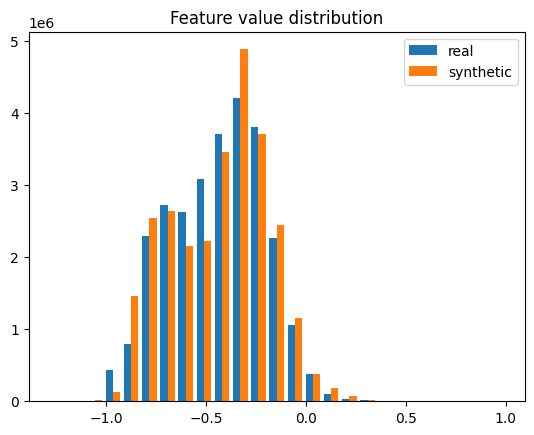

In [14]:
# Compare real and synthetic distribution of page views
plt.hist([wwt_features.flatten(),wwt_synthetic_features1.flatten()], bins=25, label=["real", "synthetic"])

plt.title("Feature value distribution")
plt.legend()
plt.show()

In [15]:
wwt_synthetic_acf1 = get_autocorr(wwt_synthetic_features1)
wwt_acf = get_autocorr(wwt_features)

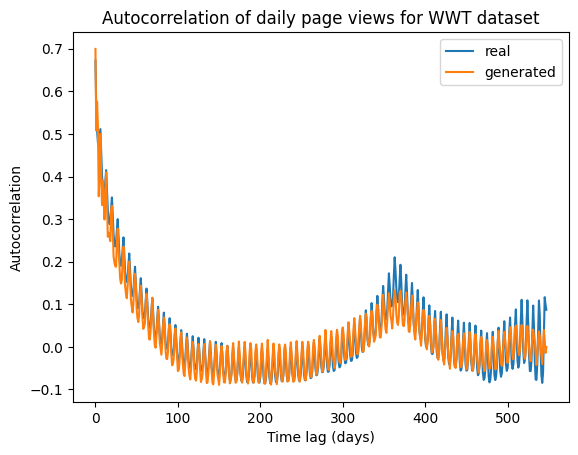

In [16]:
# Figure 1, autocorrelation
plt.plot(wwt_acf, label="real")
plt.plot(wwt_synthetic_acf1, label="generated")
plt.xlabel("Time lag (days)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of daily page views for WWT dataset")
plt.legend()
plt.show()

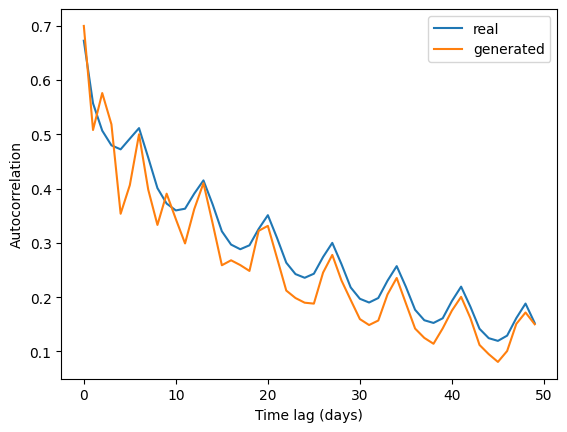

In [17]:
# Zoom in on first 50 day lags of autocorrelation
plt.plot(wwt_acf[0:50], label="real")
plt.plot(wwt_synthetic_acf1[0:50], label="generated")
plt.xlabel("Time lag (days)")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()